## In this notebook

- Create a plot of the age curve for the NHL skaters.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
sns.set_theme(style="darkgrid")

In [2]:
DATA_PATH = Path("data/player_season_stats/skaters.csv")

## Download players data

In [3]:
def download_skaters_stats_from_nhl_api(
    min_player_id: int = 8_455_000, 
    max_player_id: int = 8_485_000,
) -> None:

    # load existing data
    if DATA_PATH.exists():
        df = pd.read_csv(DATA_PATH)
        player_ids = df.player_id.unique()
    else:
        player_ids = []

    rows = []

    for player_id in tqdm(range(min_player_id, max_player_id)):
        # skip already downloaded players
        if player_id in player_ids:
            continue

        # get player info
        response = requests.get(url=f"https://api-web.nhle.com/v1/player/{player_id}/landing")

        if not response.ok:
            continue
        
        try:
            # parse data
            data = response.json()
            
            for season in data["seasonTotals"]:
                # skip non-NHL seasons
                if season["leagueAbbrev"] != "NHL":
                    continue

                # skip goalies
                if data["position"] == "G":
                    continue

                rows.append({
                    "player_id": player_id,
                    "first_name": data["firstName"]["default"],
                    "last_name": data["lastName"]["default"],
                    "position": data["position"],
                    "birth_date": data["birthDate"],
                    "birth_country": data["birthCountry"],
                    "shoots": data["shootsCatches"],
                    "season": season["season"],
                    "season_type": season["gameTypeId"],
                    "games_played": season["gamesPlayed"],
                    "goals": season["goals"],
                    "assists": season["assists"],
                    "points": season["points"],
                    "power_play_goals": season["powerPlayGoals"],
                    "power_play_points": season["powerPlayPoints"],
                    "short_handed_goals": season["shorthandedGoals"],
                    "short_handed_points": season["shorthandedPoints"],
                    "avg_toi": season["avgToi"],
                })
        
        except KeyError:
            continue

    # save data
    (
        pd
        .concat([df, pd.DataFrame(rows)])
        .drop_duplicates(subset=["player_id", "season", "season_type"])
        .sort_values(by=["player_id", "season", "season_type"])
        .to_csv(DATA_PATH, index=False)
    )

In [4]:
# read data

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
else:
    download_skaters_stats_from_nhl_api()

df.tail()

,player_id,first_name,last_name,position,birth_date,birth_country,shoots,season,season_type,games_played,goals,assists,points,power_play_goals,power_play_points,short_handed_goals,short_handed_points,avg_toi
26532,8484938,Arttu,Hyry,R,2001-04-06,FIN,R,20242025,2,5,0,1,1,0,0,0,0,9:05
26533,8484958,Maxim,Tsyplakov,R,1998-09-19,RUS,L,20242025,2,77,10,25,35,1,3,0,0,14:58
26534,8484976,Jere,Innala,L,1998-03-17,FIN,L,20242025,2,17,0,0,0,0,0,0,0,7:09
26535,8484984,Ivan,Demidov,R,2005-12-10,RUS,L,20242025,2,2,1,1,2,0,0,0,0,13:43
26536,8484984,Ivan,Demidov,R,2005-12-10,RUS,L,20242025,3,5,0,2,2,0,2,0,0,14:29


In [5]:
# merge seasons with more than 1 row/club

df = (
    df
    .assign(
        avg_toi_seconds=lambda x: (
            x.avg_toi.str.split(":").str[0].astype(int) * 60 + x.avg_toi.str.split(":").str[1].astype(int)
        ),
        weighted_toi=lambda x: x.avg_toi_seconds * x.games_played,
    )
    .groupby([
        "player_id", 
        "first_name", 
        "last_name", 
        "position", 
        "birth_date", 
        "birth_country", 
        "shoots", 
        "season", 
        "season_type",
    ])
    .agg(
        games_played=("games_played", "sum"),
        goals=("goals", "sum"),
        assists=("assists", "sum"),
        points=("points", "sum"),
        power_play_goals=("power_play_goals", "sum"),
        power_play_points=("power_play_points", "sum"),
        short_handed_goals=("short_handed_goals", "sum"),
        short_handed_points=("short_handed_points", "sum"),
        weighted_toi=("weighted_toi", "sum"),
    )
    .assign(
        avg_toi_seconds=lambda x: x.weighted_toi / x.games_played,
    )
    .drop(columns=["weighted_toi"])
    .reset_index()
)

In [6]:
# process data

df = (
    df
    # use regular season data only
    .loc[lambda x: x.season_type == 2]

    # filter out players with less than 20 games played per season
    # .loc[lambda x: x.games_played >= 20]

    .sort_values(by=["player_id", "season"])

    # create new columns
    .assign(
        age = lambda x: x.season.astype(str).str[:4].astype(int) - pd.to_datetime(x.birth_date).dt.year,
        even_strength_points = lambda x: x.points - x.power_play_points - x.short_handed_points,
        # points per game
        ppg = lambda x: x.points / x.games_played,
        even_strength_ppg = lambda x: x.even_strength_points / x.games_played,
        # calculate the age difference and the pct change in even strength points per game
        age_diff=lambda x: x.groupby("player_id").age.diff(),
        even_strength_ppg_pct_change=lambda x: x.groupby("player_id").even_strength_ppg.pct_change(),
        avg_toi_seconds_pct_change=lambda x: x.groupby("player_id").avg_toi_seconds.pct_change(),
    )

    # filter out players with age outside of 19-35
    .loc[lambda x: (x.age >= 19) & (x.age <= 35)]

    # reset index
    .reset_index(drop=True)
)

## Create the age curve

In [7]:
def plot_age_curve(
    age_stats: pd.DataFrame,
    y_col: str,
    title: str,
    x_label: str,
    y_label: str,
) -> None:
    ax = (
        age_stats
        .plot(
            y=y_col,
            kind="line",
            figsize=(10, 5),
            legend=False,
        )
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    plt.xticks(range(age_stats.index.min(), age_stats.index.max() + 1))
    plt.show()

#### Average points per game by age

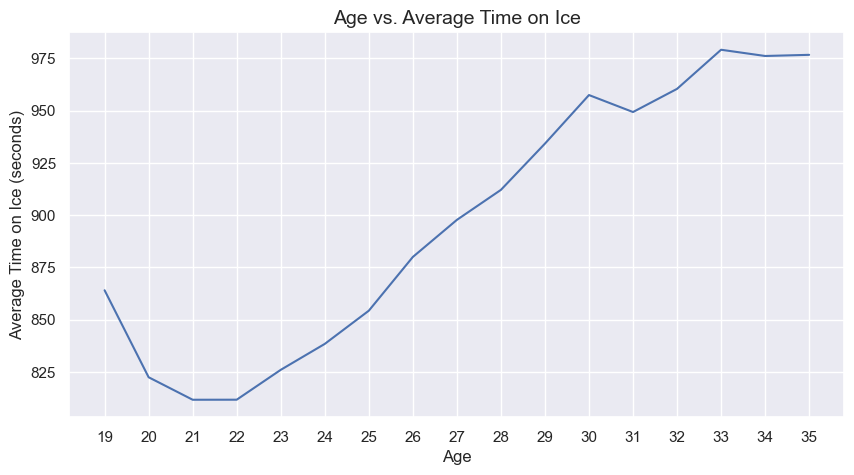

In [8]:
age_stats = (
    df
    .groupby("age")
    .agg(
        even_strength_ppg_avg=("even_strength_ppg", "mean"),
        even_strength_ppg_median=("even_strength_ppg", "median"),
        ppg_avg=("ppg", "mean"),
        ppg_median=("ppg", "median"),
        toi_avg=("avg_toi_seconds", "mean"),
        toi_median=("avg_toi_seconds", "median"),
        players_count=("player_id", "count"),
    )
)

plot_age_curve(
    age_stats=age_stats, 
    y_col="toi_avg", 
    title="Age vs. Average Time on Ice", 
    x_label="Age", 
    y_label="Average Time on Ice (seconds)",
)

#### Delta method

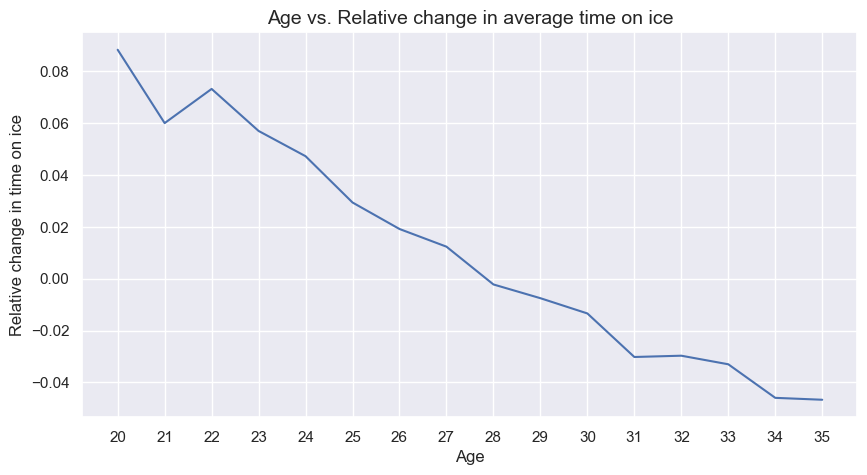

In [9]:
age_stats_delta = (
    df
    .loc[lambda x: x.even_strength_ppg > 0.0]

    .assign(
        age_diff=lambda x: x.groupby("player_id").age.diff(),
        even_strength_ppg_pct_change=lambda x: x.groupby("player_id").even_strength_ppg.pct_change(),
        avg_toi_seconds_pct_change=lambda x: x.groupby("player_id").avg_toi_seconds.pct_change(),
    )
    
    # leave only deltas between consecutive ages, and filter out first players' seasons without any pct change
    .loc[lambda x: x.age_diff == 1 & x.even_strength_ppg_pct_change.notna()]
    
    # calculate the average of the pct changes
    .groupby("age")
    .agg(
        even_strength_ppg_pct_change_avg=("even_strength_ppg_pct_change", "mean"),
        avg_toi_seconds_pct_change_avg=("avg_toi_seconds_pct_change", "mean"),
        players_count=("player_id", "count"),
    )
)

plot_age_curve(
    age_stats=age_stats_delta, 
    y_col="avg_toi_seconds_pct_change_avg", 
    title="Age vs. Relative change in average time on ice", 
    x_label="Age", 
    y_label="Relative change in time on ice",
)

#### Smoothing

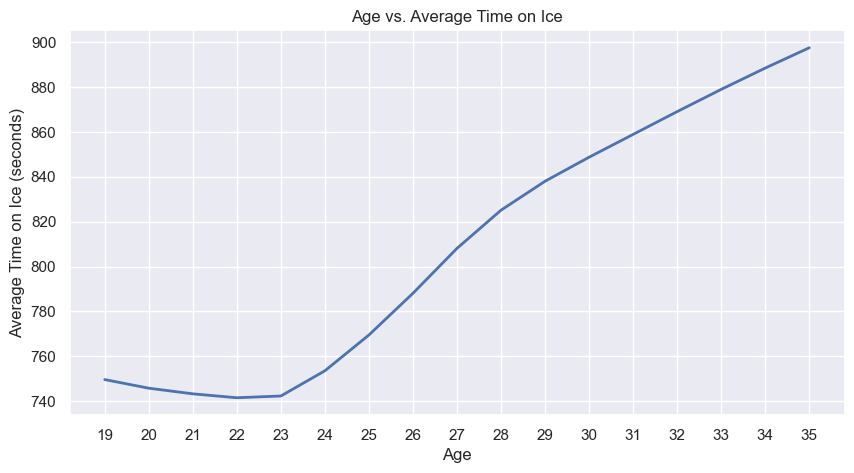

In [10]:
# Set up the figure
fig, ax = plt.subplots(
    figsize=(10, 5),
)

sns.regplot(
    data=df.loc[lambda x: x.position != "D"],
    x="age",
    y="avg_toi_seconds",
    ax=ax,
    lowess=True,
    scatter=False,
    line_kws={"linewidth": 2},
    label="Smoothed Avg (LOWESS)",
)

# Final formatting
ax.set_xlabel("Age")
ax.set_ylabel("Average Time on Ice (seconds)")
ax.set_title("Age vs. Average Time on Ice")

plt.xticks(range(df.age.min(), df.age.max() + 1))
plt.show()

In [11]:
def plot_age_curve_with_lowess_and_ci(
    df: pd.DataFrame,
    col: str,
    title: str,
    x_label: str,
    y_label: str,
    n_bootstraps: int = 100,
) -> None:
    lowess = sm.nonparametric.lowess
    lowess_orig = lowess(endog=df[col], exog=df["age"], frac=0.5, return_sorted=True)
    ages_smooth = np.unique(df["age"])

    # bootstrap data
    bootstrap_results = []

    for _ in range(n_bootstraps):
        sample = df.sample(frac=1, replace=True)
        lowess_sample = lowess(sample[col], sample["age"], frac=0.3, return_sorted=True)
        bootstrap_results.append(
            pd.DataFrame(lowess_sample, columns=["age", col])
            .groupby("age")
            .mean()
            .reindex(ages_smooth, method="nearest")
            .loc[:, col]
            .values
        )

    # compute the confidence interval
    bootstrap_results = np.array(bootstrap_results)
    ci_lower = np.percentile(bootstrap_results, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_results, 97.5, axis=0)

    # plot the smoothed line and the confidence interval
    _, ax = plt.subplots(
        figsize=(10, 5),
    )

    # ax.plot(lowess_orig[:, 0], lowess_orig[:, 1], color="black", linewidth=2, label="Smoothed Avg (LOWESS)")
    # ax.fill_between(ages_smooth, ci_lower, ci_upper, color="black", alpha=0.1, label="95% CI")
    ax.plot(lowess_orig[:, 0], lowess_orig[:, 1], linewidth=2, label="Smoothed Avg (LOWESS)")
    ax.fill_between(ages_smooth, ci_lower, ci_upper, alpha=0.1, label="95% Confidence Interval")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=14)
    ax.legend()

    plt.xticks(range(df.loc[df[col].notna()].age.min(), df.loc[df[col].notna()].age.max() + 1))
    plt.tight_layout()
    plt.show()

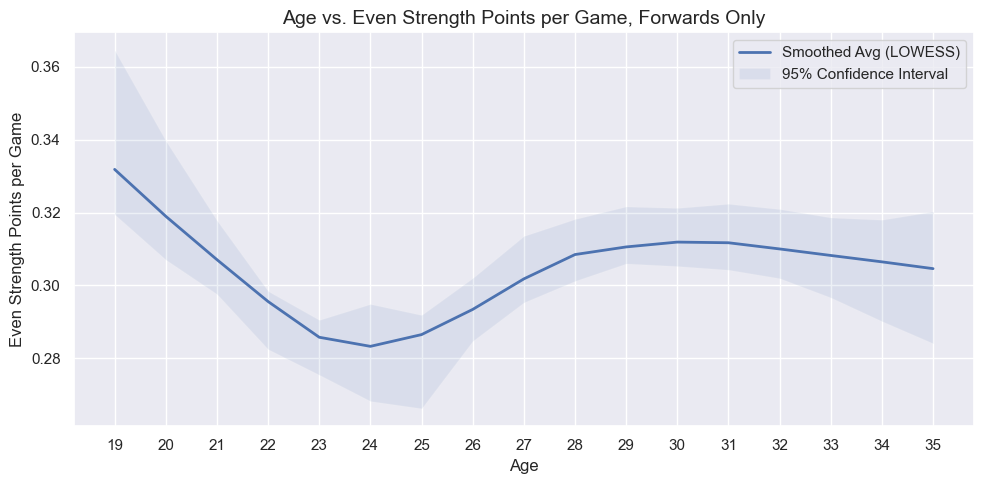

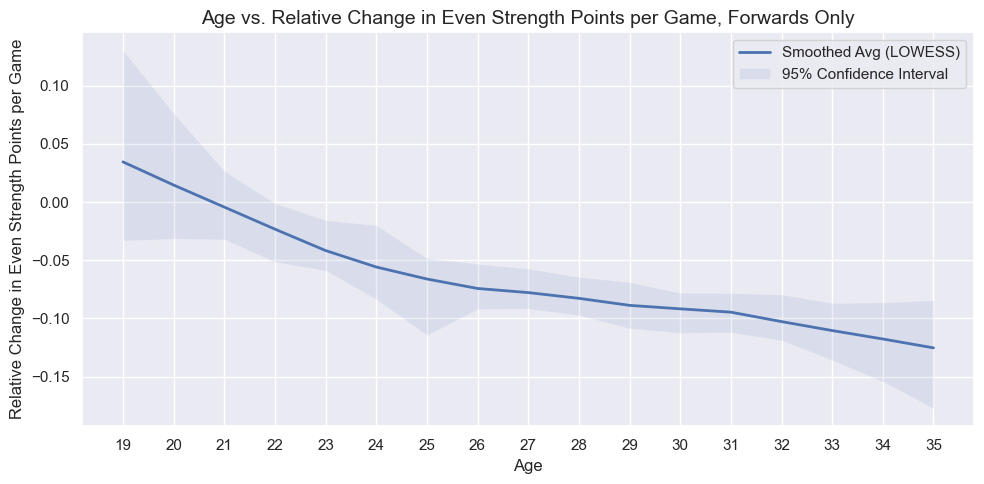

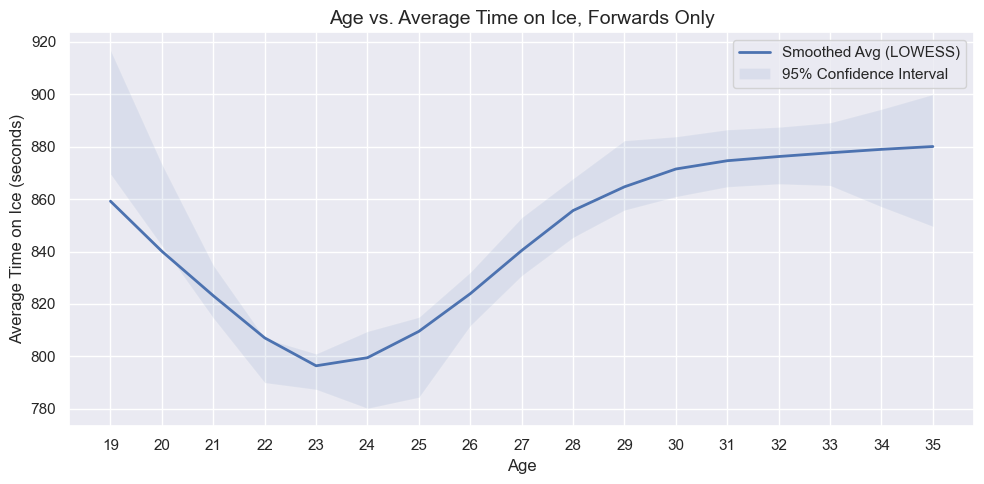

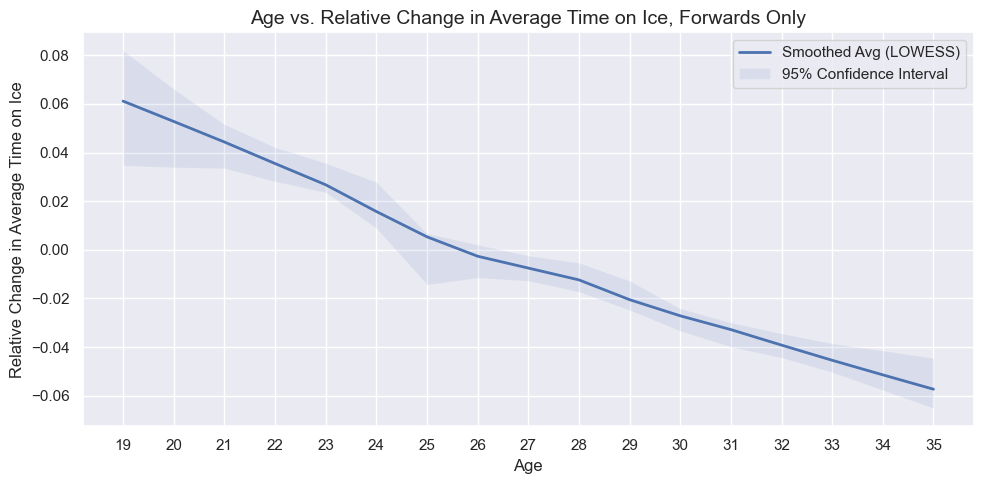

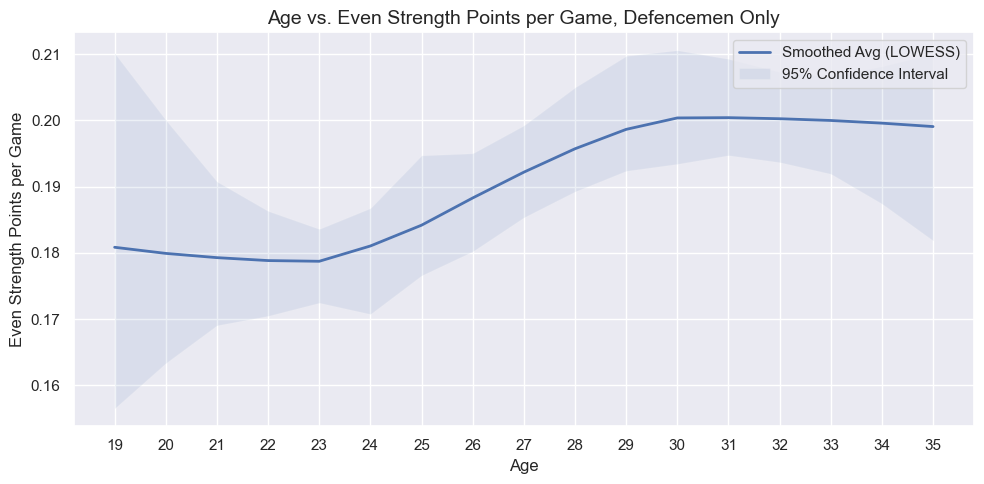

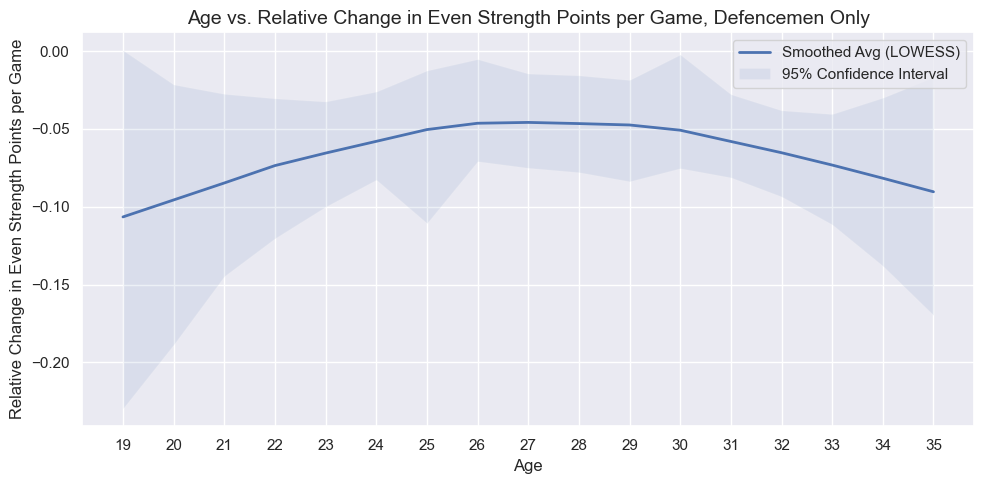

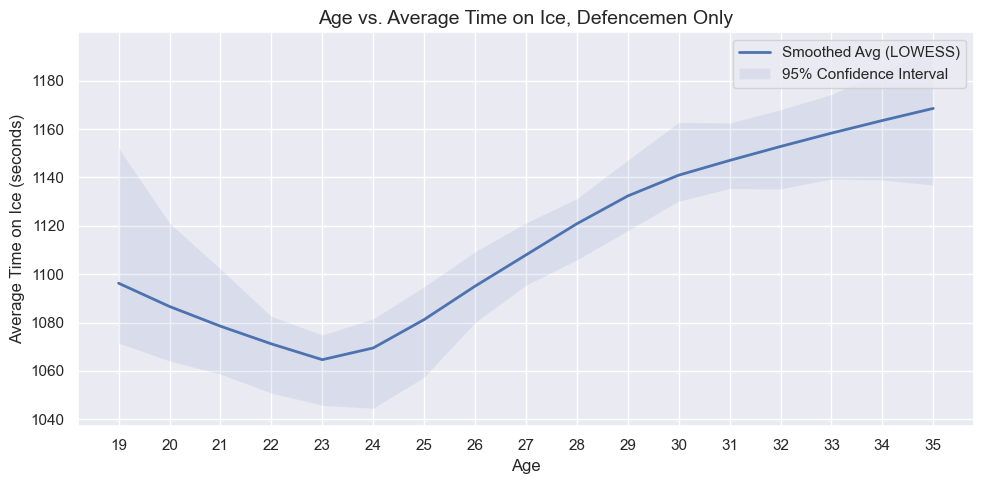

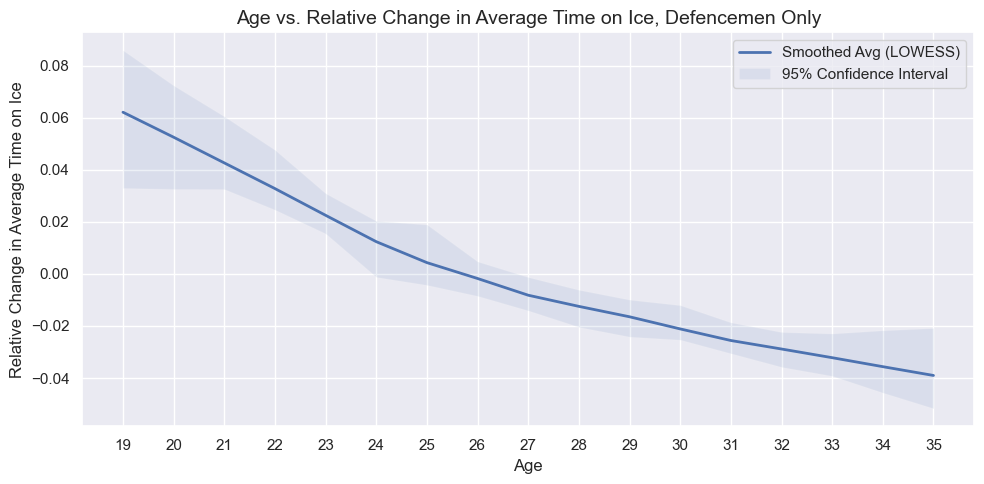

In [12]:
df_forwards = df.loc[lambda x: (x.position != "D") & (x.age_diff == 1)]
df_defencemen = df.loc[lambda x: (x.position == "D") & (x.age_diff == 1)]

for _df, position_desc in [(df_forwards, "Forwards"), (df_defencemen, "Defencemen")]:

    plot_age_curve_with_lowess_and_ci(
        df=_df,
        col="even_strength_ppg",
        title=f"Age vs. Even Strength Points per Game, {position_desc} Only",
        x_label="Age",
        y_label="Even Strength Points per Game",
    )

    plot_age_curve_with_lowess_and_ci(
        df=_df,
        col="even_strength_ppg_pct_change",
        title=f"Age vs. Relative Change in Even Strength Points per Game, {position_desc} Only",
        x_label="Age",
        y_label="Relative Change in Even Strength Points per Game",
    )

    plot_age_curve_with_lowess_and_ci(
        df=_df,
        col="avg_toi_seconds",
        title=f"Age vs. Average Time on Ice, {position_desc} Only",
        x_label="Age",
        y_label="Average Time on Ice (seconds)",
    )

    plot_age_curve_with_lowess_and_ci(
        df=_df,
        col="avg_toi_seconds_pct_change",
        title=f"Age vs. Relative Change in Average Time on Ice, {position_desc} Only",
        x_label="Age",
        y_label="Relative Change in Average Time on Ice",
    )

## Results

- Created age curves for the NHL skaters.